In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
type(mnist) # Аналог словаря

sklearn.utils.Bunch

In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

(-0.5, 27.5, 27.5, -0.5)

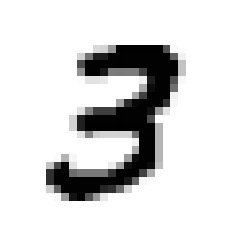

In [ ]:
plt.imshow(X[7].reshape(28, 28), cmap="binary")
plt.axis("off")

In [ ]:
y[7]

'3'

In [ ]:
y = y.astype(np.int32) # т.к. изначально строка

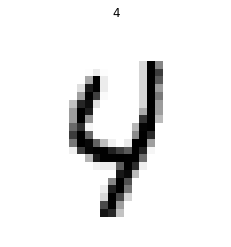

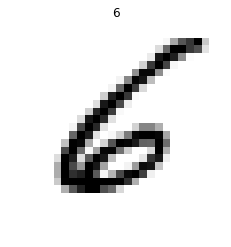

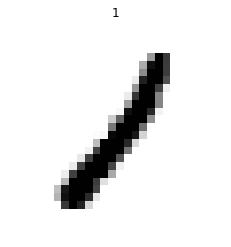

In [ ]:
for i in range(3):
    idx = np.random.randint(69999)
    plt.imshow(X[idx].reshape((28,28)), cmap='binary')
    plt.axis("off")
    plt.title(f"{y[idx]}")
    plt.show()

In [ ]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:] # Разбиваем на обучающее и тестовое множество

# Бинарный классификатор

In [ ]:
y_train_7 = (y_train == 7)
y_test_7 = (y_test == 7)

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([X_train[15]])

array([ True])

In [ ]:
y[15]

7

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pred = sgd_clf.predict(X_train)
accuracy_score(y_train_7, pred)

0.9856833333333334

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Собственный KFold валидатор
strat_k_fold = StratifiedKFold(5)
for tr_idx, tst_idx in strat_k_fold.split(X_train, y_train_7):
    sgd_clf = SGDClassifier(random_state=42)
    X_train_folds = X_train[tr_idx]
    y_train_folds = y_train_7[tr_idx]
    X_val_folds = X_train[tst_idx]
    y_val_folds = y_train_7[tst_idx]
    sgd_clf.fit(X_train_folds, y_train_folds)
    pred = sgd_clf.predict(X_val_folds)
    print("Built in function accuracy: {}".format(accuracy_score(y_val_folds, pred)))

Built in function accuracy: 0.9803333333333333
Built in function accuracy: 0.9825
Built in function accuracy: 0.9733333333333334
Built in function accuracy: 0.97725
Built in function accuracy: 0.9763333333333334


In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(SGDClassifier(random_state=42), X_train, y_train_7, scoring="accuracy", cv=5)

array([0.98033333, 0.9825    , 0.97333333, 0.97725   , 0.97633333])

In [ ]:
zeros_pred = np.zeros(y_train_7.shape[0])
accuracy_score(y_train_7, zeros_pred)
# Из результата видно, что accuracy - не лучшая оценка для проверки модели.

0.8955833333333333

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict

In [ ]:
pred = cross_val_predict(SGDClassifier(random_state=42), X_train, y_train_7, cv=5)
confusion_matrix(y_train_7, pred, labels=[0,1])

array([[53180,   555],
       [  768,  5497]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision_score(y_train_7, pred) # Классификатор определяет 7-ку с 90% вероятностью
# Отображает точность прогнозов как отношение TP / (TP + FP).
# Точность важна в тех случаях, когда важно исключить ошибки ценой количества
# (Алгоритм выдаёт только правильные результаты, жертуя их количеством)

0.9082947785855915

In [ ]:
recall_score(y_train_7, pred) # Классификатор определяет 87% 7-ок 
# Отображает полноту прогнозов как отношение TP / (TP + FN)
# Или же способность модели количественно захватить больше правильных, жертвуя
# точностью


0.877414205905826

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_train_7, pred) # Среднее гармоническое точности и полноты
#Метрика F1 придаёт низким значениям больший вес
#Поэтому оценка будет высока, когда и точность, и общность высоки одновременно

0.8925874807177073

In [ ]:
y_scores = sgd_clf.decision_function([X_train[15]]) # выдаёт сумму очков от модели
y_scores

array([5004.34292937])

In [ ]:
threshold = 0
some_dig_pred = bool(y_scores > threshold)
some_dig_pred, y_train_7[15]
#Устанавливаем пороговое значение, по которому классификатор будет определять
#принадлежность к классу

(True, True)

In [ ]:
y_scores = sgd_clf.decision_function([X_train[0]])
y_scores

array([-13343.60257777])

In [ ]:
some_dig_pred = bool(y_scores > threshold)
some_dig_pred, y_train_7[0]

(False, False)

In [ ]:
y_scores = cross_val_predict(SGDClassifier(random_state=42), X_train, y_train_7,
                             method="decision_function", cv=3)
# Изменяем метод с предиктов на сумму очков

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
precision, recall, threshold = precision_recall_curve(y_train_7, y_scores)

In [ ]:
def plot_decision_recall_threshold(precisions, recalls, thresholds, idx_prec = None):
    """Функция вычерчивает график точности и полноты в зависимости от порога"""
    plt.plot(thresholds, precisions[:-1], label="Prec")
    plt.plot(thresholds, recalls[:-1], label="Rec")
    if idx_prec is not None:
        plt.scatter((thresholds[idx_prec], thresholds[idx_prec]), (precisions[idx_prec], recalls[idx_prec]))
    plt.title("График зависимостей точности, полноты от порога")
    plt.legend()


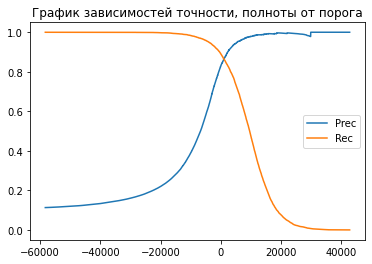

In [ ]:
plot_decision_recall_threshold(precision, recall, threshold)

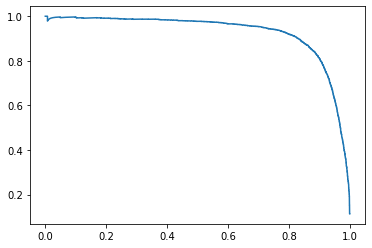

In [ ]:
plt.plot(recall, precision) # График зависимости точности от полноты

In [ ]:
idx_prec = np.argmax(precision >= 0.9) # Первый индекс в котором точность приблизительно равно 90%
print(f"{idx_prec}")
thres_90 = threshold[idx_prec] # Найдём пороговое значение, для такой точности
print("Пороговое значение для заданной точности: {}".format(thres_90))
print("Значение точности: {}".format(precision[idx_prec]))
print("Значение полноты: {}".format(recall[idx_prec]))

49589
Пороговое значение для заданной точности: 2288.724768166237
Значение точности: 0.9000864304235091
Значение полноты: 0.8311252992817239


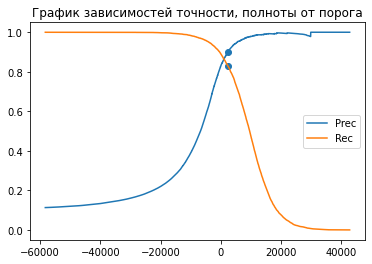

In [ ]:
plot_decision_recall_threshold(precision, recall, threshold, idx_prec)

In [ ]:
y_train_pred_90 = (y_scores >= thres_90).astype('bool') # Предикты на основе порога
accuracy_score(y_train_7, y_train_pred_90)

0.9727333333333333

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, threshold = roc_curve(y_train_7, y_scores)

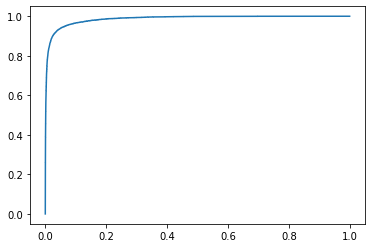

In [ ]:
plt.plot(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_train_7, y_scores) # Площадь под кривой (выше), чем ближе к 1, тем лучше

0.986670497551944

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train_7)
accuracy_score(y_train_7, rnd_clf.predict(X_train))

1.0

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)
rnd_prob = cross_val_predict(forest_clf, X_train, y_train_7, cv=3, method="predict_proba")
rnd_prob[:5]

array([[0.98, 0.02],
       [1.  , 0.  ],
       [0.89, 0.11],
       [1.  , 0.  ],
       [0.95, 0.05]])

In [ ]:
fpr_frst, tpr_frst, thres = roc_curve(y_train_7, rnd_prob[:, 1])

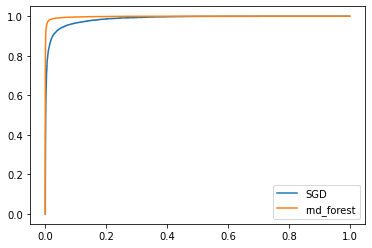

In [ ]:
plt.plot(fpr, tpr, label="SGD")
plt.plot(fpr_frst, tpr_frst, label = "rnd_forest")
plt.legend()

In [ ]:
roc_auc_score(y_train_7, rnd_prob[:,1])

0.9982747530426836

In [ ]:
y_train_pred_forest = cross_val_predict(RandomForestClassifier(random_state=42), X_train, y_train_7, cv=3)
precision_score(y_train_7, y_train_pred_forest)

0.9867364746945899

In [ ]:
recall_score(y_train_7, y_train_pred_forest)

0.9024740622505986

# Многоклассовая классификация  
Разичают более 2 классов

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([X_train[15]]) # предикт 7

array([7], dtype=int32)

In [ ]:
some_digit_scores=svm_clf.decision_function([X_train[15]]) # получим очки предиктов
some_digit_scores

array([[ 3.7729373 , -0.28076009,  2.77415891,  1.72592896,  7.2279545 ,
         5.83895284,  0.7133311 ,  9.3066972 ,  4.79191747,  8.30085892]])

In [ ]:
np.argmax(some_digit_scores) # наибольшее значение под 7 индексом

7

In [ ]:
svm_clf.classes_ # под 7 индексом значение 7

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

(-0.5, 27.5, 27.5, -0.5)

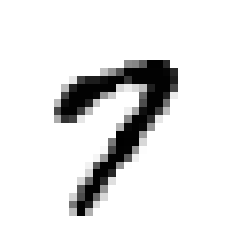

In [ ]:
plt.imshow(X_train[15].reshape(28, 28), cmap='binary')
plt.axis("off")

In [ ]:
from sklearn.multiclass import OneVsRestClassifier # Обучается n классификаторов, резалт - наибольший балл

In [ ]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [ ]:
ovr_clf.predict([X_train[15]])

array([7], dtype=int32)

In [ ]:
ovr_clf.decision_function([X_train[15]])

array([[-1.21043017, -1.69873115, -1.75653909, -1.80833753, -1.1918236 ,
        -1.27156912, -1.83613816,  0.90220065, -1.33875738, -0.7918755 ]])

In [ ]:
print("Индекс макс. элемента: {}".format(np.argmax(ovr_clf.decision_function([X_train[15]]))))
print("Классы: {}".format(ovr_clf.classes_))

Индекс макс. элемента: 7
Классы: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
from sklearn.multiclass import OneVsOneClassifier

In [ ]:
ono_clf = OneVsOneClassifier(SVC(random_state=42))
ono_clf.fit(X_train[:1000], y_train[:1000])

OneVsOneClassifier(estimator=SVC(random_state=42))

In [ ]:
ono_clf.predict([X_train[15]])

array([7], dtype=int32)

In [ ]:
ono_clf.decision_function([X_train[15]])

array([[ 3.77495038, -0.27873267,  2.7712187 ,  1.72570399,  7.2291282 ,
         5.84558667,  0.71339197,  9.30634409,  4.7939614 ,  8.30027674]])

In [ ]:
print("Индекс макс. элемента: {}".format(np.argmax(ono_clf.decision_function([X_train[15]]))))
print("Классы: {}".format(ono_clf.classes_))

Индекс макс. элемента: 7
Классы: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
sgd_clf = SGDClassifier(random_state=42) # Алгоритм на основе градиента способен предиктить значения без обучения множества 2-ых классификаторов
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([X_train[15]])

array([7], dtype=int32)

In [ ]:
sgd_clf.decision_function([X_train[15]])

array([[-21644.21154705, -30813.5490348 , -24237.31532374,
         -9608.2729414 , -12980.58270687,  -7511.22550981,
        -39999.81058079,   6397.47330052,  -2860.94256874,
          1049.86877291]])

In [ ]:
print("Индекс макс. элемента: {}".format(np.argmax(sgd_clf.decision_function([X_train[15]]))))
print("Классы: {}".format(sgd_clf.classes_))

Индекс макс. элемента: 7
Классы: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Собственный KFold валидатор
strat_k_fold = StratifiedKFold(3)
for tr_idx, tst_idx in strat_k_fold.split(X_train, y_train):
    sgd_clf = SGDClassifier(random_state=42)
    X_train_folds = X_train[tr_idx]
    y_train_folds = y_train[tr_idx]
    X_val_folds = X_train[tst_idx]
    y_val_folds = y_train[tst_idx]
    sgd_clf.fit(X_train_folds, y_train_folds)
    pred = sgd_clf.predict(X_val_folds)
    print("Built in function accuracy: {}".format(accuracy_score(y_val_folds, pred)))

Built in function accuracy: 0.87365
Built in function accuracy: 0.85835
Built in function accuracy: 0.8689


In [ ]:
cross_val_score(SGDClassifier(random_state=42), X_train, y_train, scoring='accuracy', cv=3)

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
simple_pred = np.array([7]*y_train.shape[0])
accuracy_score(y_train, simple_pred)
# SGD не плохо справляется относительно простого алгоритма, который всегда предиктит 7

0.10441666666666667

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)

In [ ]:
cross_val_score(SGDClassifier(random_state=42), X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [ ]:
y_train_pred = cross_val_predict(SGDClassifier(random_state=42), X_train_scaled, y_train, cv=3)

In [ ]:
conf_mtx = confusion_matrix(y_train, y_train_pred)
conf_mtx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [ ]:
import seaborn as sns

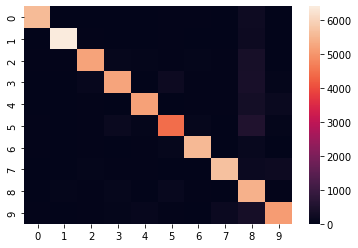

In [ ]:
sns.heatmap(conf_mtx)
# Из матрицы(графической) видно, пятёрки ошибочно классифицируются как 8.

In [ ]:
conf_mx_row_sum = conf_mtx.sum(axis=1, keepdims=True)
conf_mx_row_sum

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

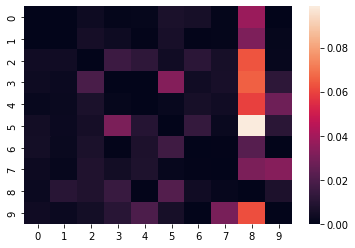

In [ ]:
norm_conf_mx = conf_mtx / conf_mx_row_sum
np.fill_diagonal(norm_conf_mx, 0)
sns.heatmap(norm_conf_mx)
# при занулении диагонали, сразу видно проблемную взаимосвязь всех цифр с 8

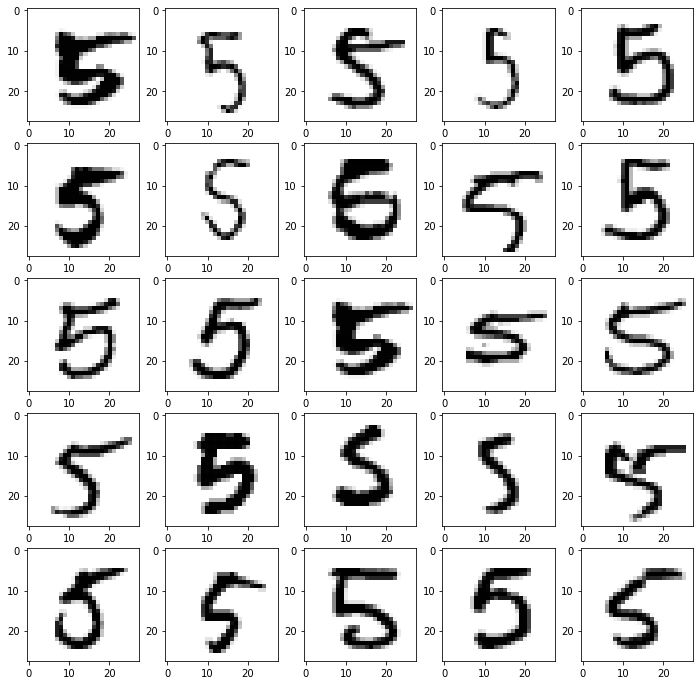

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(12, 12))
for row in range(5):
    for col in range(5):
        ax[row, col].imshow(X_train[y_train==5][np.random.randint(0, 3000)].reshape((28, 28)), cmap='binary')
        

# Многозначная классификация  
Смысл в предикте нескольких значений сразу

In [84]:
from sklearn.neighbors import KNeighborsClassifier

In [88]:
y_train_large = (y_train >= 7) 
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [89]:
knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [95]:
print("Число: {}".format(y_train[15]))
print(">= 7: {}\t%2 == 1: {}".format(y_train_large[15], y_train_odd[15]))
print("Предсказанное значение алгоритма: {}".format(knn_clf.predict([X_train[15]])))

Число: 7
>= 7: True	%2 == 1: True
Предсказанное значение алгоритма: [[ True  True]]
